In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import sin, cos, tan, atan, cosh, sinh, tanh, abs, linspace, min, max, argmin, argmax, pi, mean

# plt.rcParams.update({
#     'figure.facecolor': '#121212',
#     'figure.figsize': (12, 6),
#     'axes.facecolor': '#1e1e1e',
#     # 'axes.edgecolor': '#4a90e2',
#     'lines.linewidth': 1,
#     # 'lines.color': '#4a90e2',
#     'text.color': '#cccccc',
#     'axes.labelcolor': '#cccccc',
#     'xtick.color': '#bbbbbb',
#     'ytick.color': '#bbbbbb',
#     # 'axes.titlecolor': '#4a90e2',
#     'axes.titlesize': 18,
#     'axes.labelsize': 14,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12,
#     'grid.color': '#333f58',
#     'grid.linestyle': '--',
#     'grid.linewidth': 0.7,
#     'axes.grid': True,
#     'legend.facecolor': '#2c2c2c',
#     # 'legend.edgecolor': '#4a90e2',
#     'legend.fontsize': 12,
#     'legend.fancybox': True,
#     'savefig.facecolor': '#121212',
#     'savefig.edgecolor': '#121212',
# })

plt.rcParams.update({'figure.figsize': (20, 12)})


np.set_printoptions(
    formatter={'float_kind': lambda x: f"{x:.2e}"}
    #formatter={'float_kind': lambda x: f"{x:.2g}"},
    #suppress=False 
)


In [3]:
# constants:
A = 0.84
kappa = 1.7e1
H = 12
L = 1.9e4
r = 0.24
h0 = 0.0025
# h0 = 0.00025
omega = 1.4e-4



def perform_numerical_computation(A, kappa, H, r, h0, nx):

    dx = 1 / nx

    
    dt = 0.9 / np.sqrt(kappa) * dx
    nt = int(30 / dt)


    

    print(dt, dx)


    x_x = np.linspace(-dx, 1 + dx, nx + 2)

    u_xt_ = np.zeros((nx + 2, nt + 1))
    D_xt_ = np.zeros((nx + 2, nt + 1))
    l_t_ = np.zeros(nt + 1)

    D_xt_[0, 0] = 1 + A / H
    D_xt_[:, 0] = (H + A) / H - x_x # since x_x = h_x
    l_t_[0] = 1 # 2e4 / 1.9e4



    def update_l(l__t, u_x_t, dt):
        return l__t + u_x_t[-2] * dt

    def update_D(l__t1, l__t2, u_x_t, x_x, D_x_t, dt, dx, t):
        D_x_t2 = np.zeros(nx + 2)
        D_x_t2[0] = A / H * np.cos(t) + 1
        D_x_t2[-1] = 0 # redundant


        dDdx =  (D_x_t[2:] - D_x_t[:-2]) / (2 * dx)
        dDudx = (D_x_t[2:] * u_x_t[2:] - D_x_t[:-2] * u_x_t[:-2]) / (2 * dx)


        D_x_t2[1:-1] = (D_x_t[2:] + D_x_t[:-2]) / 2 \
                        + x_x[1:-1] / l__t1 * (l__t2 - l__t1) * dDdx \
                        - dt / l__t1 * dDudx
        
        return D_x_t2


    def update_u(l__t1, l__t2, u_x_t, x_x, h_x, D_x_t, D_x_t2, dt, dx):
        Lambda = r / (D_x_t2 + h0)

        u_x_t2 = np.zeros(nx + 2)

        dudx = (-3 * u_x_t[0] + 4 * u_x_t[1] - u_x_t[2]) / (2*dx)
        dDdx = (-3 * D_x_t[0] + 4 * D_x_t[1] - D_x_t[2]) / (2*dx)
        dhdx = (-3 * h_x[0] + 4 * h_x[1] - h_x[2]) / (2*dx)

        u_x_t2[0]    = (
                            u_x_t[0] \
                            + dt / l__t1 * u_x_t[0] * dudx 
                            - dt / l__t1 * kappa * (dDdx + dhdx)
                        ) / (1 + Lambda[0] * dt)

        dudx = -(-3 * u_x_t[-1] + 4 * u_x_t[-2] - u_x_t[-3]) / (2*dx)
        dDdx = -(-3 * D_x_t[-1] + 4 * D_x_t[-2] - D_x_t[-3]) / (2*dx)
        dhdx = -(- 3 * h_x[-1] + 4 * h_x[-2] - h_x[-3]) / (2*dx)

        u_x_t2[-1]   = (
                            u_x_t[-1] \
                            + dt / l__t1 * ((l__t2 - l__t1) / dt - u_x_t[-1]) * dudx # this is zero???
                            - dt / l__t1 * kappa * (dDdx + dhdx)
                        ) / (1 + Lambda[-1] * dt)
        

        dudx = (u_x_t[2:] - u_x_t[:-2]) / (2*dx)
        dDdx = (D_x_t[2:] - D_x_t[:-2]) / (2*dx)
        dhdx = (h_x[2:] - h_x[:-2]) / (2*dx)


        u_x_t2[1:-1] = (
                            (u_x_t[2:] + u_x_t[:-2]) / 2 \
                            + dt / l__t1 * (x_x[1:-1] * (l__t2 - l__t1) / dt - u_x_t[1:-1]) * dudx \
                            - dt / l__t1 * kappa * (dDdx + dhdx)
                        ) / (1 + Lambda[1:-1] * dt)
        
        return u_x_t2


    for timestep in range(nt):
        l_t_[timestep + 1] = update_l(l_t_[timestep], u_xt_[:, timestep], dt)
        D_xt_[:, timestep + 1] = update_D(l_t_[timestep], l_t_[timestep + 1], u_xt_[:, timestep], x_x, D_xt_[:, timestep], dt, dx, timestep * dt)
        u_xt_[:, timestep + 1] = update_u(l_t_[timestep], l_t_[timestep + 1], u_xt_[:, timestep], x_x, x_x * l_t_[timestep], D_xt_[:, timestep], D_xt_[:, timestep + 1], dt, dx)

    t = np.linspace(0, dt * nt, nt + 1)
    return t, x_x, l_t_, D_xt_, u_xt_




0.002182820625326997 0.01
0.0004365641250653994 0.002
0.0002182820625326997 0.001


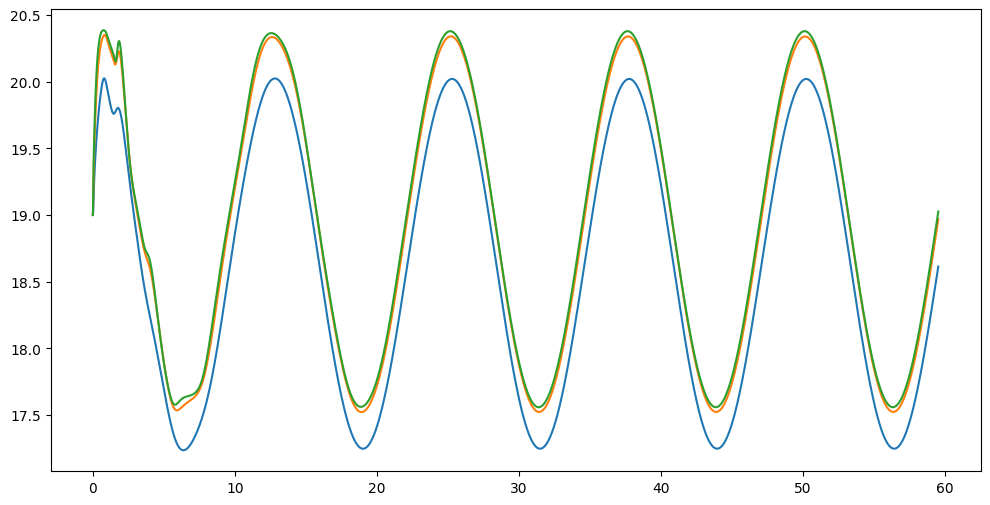

In [3]:
nx = 500

for nx in [100, 500, 1000]:

    t, x_x, l_t_, D_xt_, u_xt_ = perform_numerical_computation(A, kappa, H, r, h0, nx)
    #plt.plot(t[len(t)*3//4:] / omega / 3600, l_t_[len(t)*3//4:] * L / 1000)
    plt.plot(t / omega / 3600, l_t_ * L / 1000)




In [26]:
nx = 1000
t, x_x, l_t_, D_xt_, u_xt_ = perform_numerical_computation(A, kappa, H, r, h0, nx)


print(max(l_t_))

0.0002182820625326997 0.001
1.0729115926593429


137437


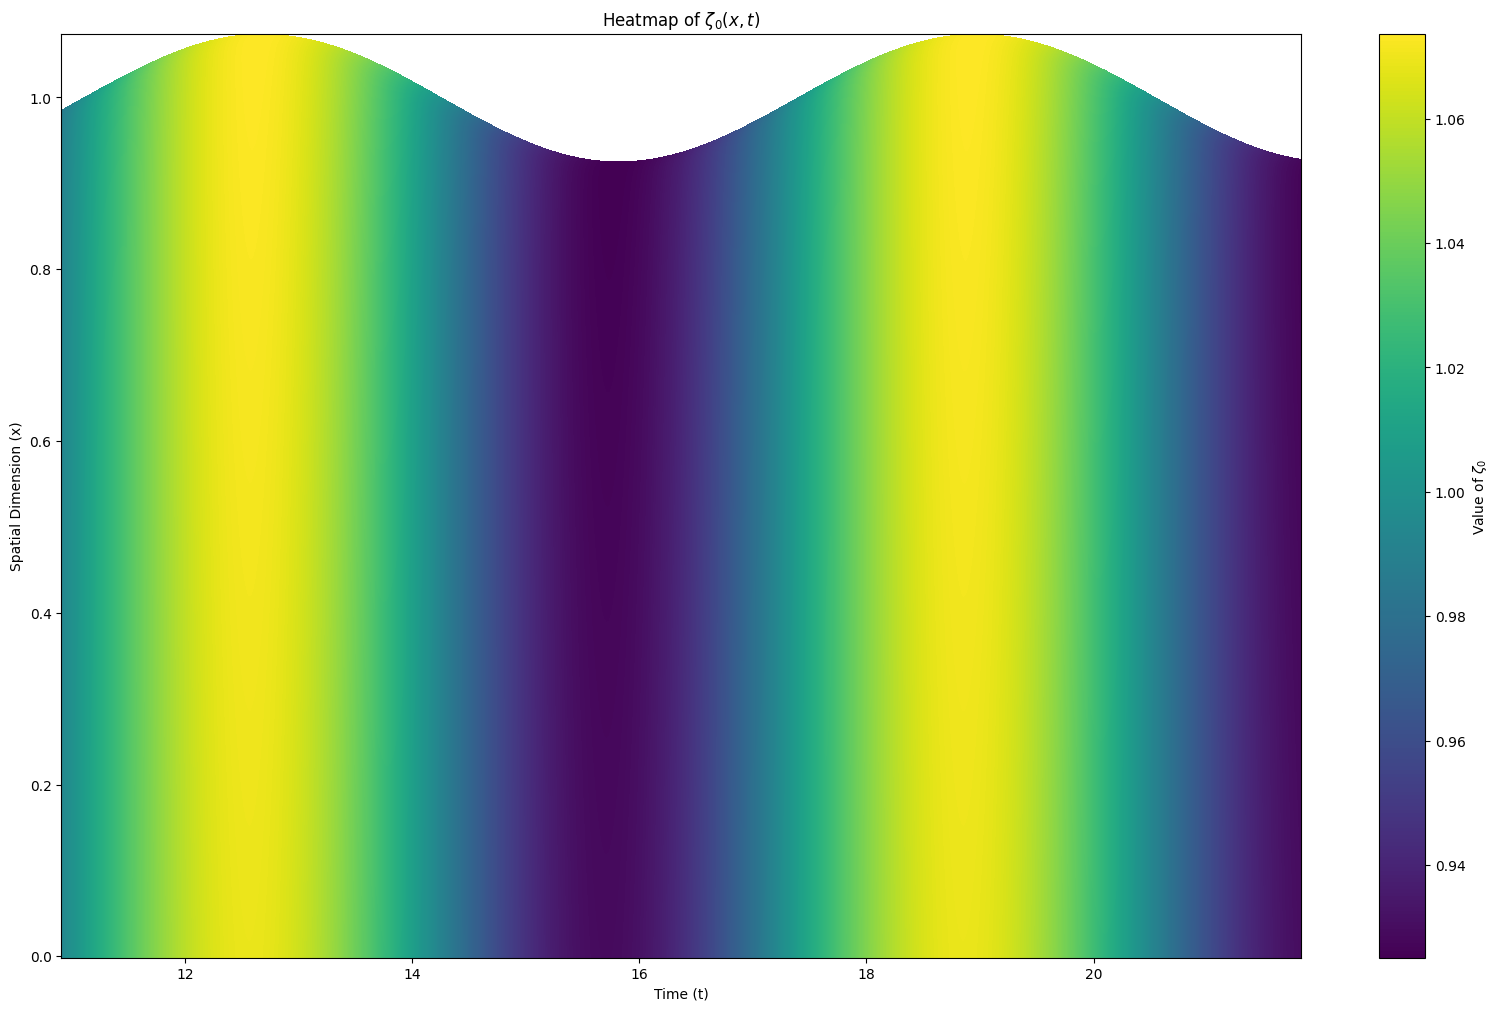

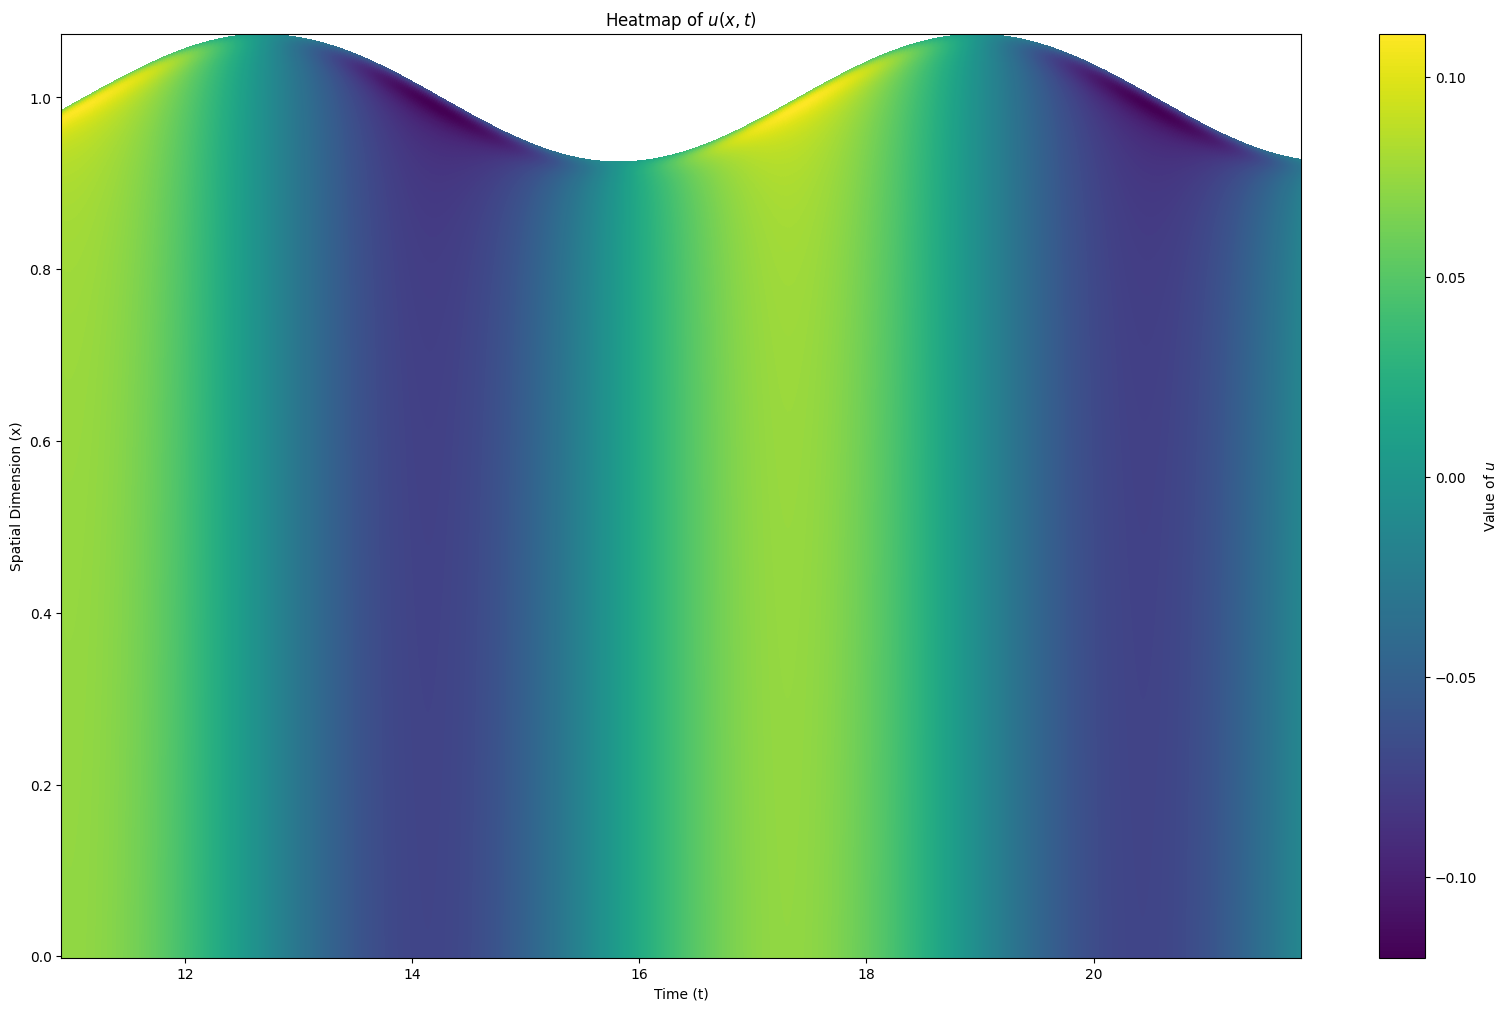

In [23]:
print(len(t))
start = 50000
end = 100000
step = 10


fig, ax = plt.subplots()

T_mesh = np.tile(t[start:end:step], (len(x_x), 1))
# X_mesh = np.tile((x_x*l_t).reshape(-1, 1), (1, len(t)))
X_mesh = x_x[:, np.newaxis] * l_t_[start:end:step][np.newaxis, :]


im = ax.pcolormesh(T_mesh, X_mesh, D_xt_[:, start:end:step] + X_mesh, cmap='viridis', shading='nearest')
fig.colorbar(im, ax=ax, label='Value of $\\zeta_0$')

ax.set_xlabel('Time (t)')
ax.set_ylabel('Spatial Dimension (x)')
ax.set_title('Heatmap of $\\zeta_0(x,t)$')

plt.show()



fig, ax = plt.subplots()

T_mesh = np.tile(t[ start:end:step], (len(x_x), 1))
# X_mesh = np.tile((x_x*l_t).reshape(-1, 1), (1, len(t)))
X_mesh = x_x[:, np.newaxis] * l_t_[ start:end:step][np.newaxis, :]


im = ax.pcolormesh(T_mesh, X_mesh, u_xt_[:,  start:end:step], cmap='viridis', shading='nearest')
fig.colorbar(im, ax=ax, label='Value of $u$')

ax.set_xlabel('Time (t)')
ax.set_ylabel('Spatial Dimension (x)')
ax.set_title('Heatmap of $u(x,t)$')

plt.show()



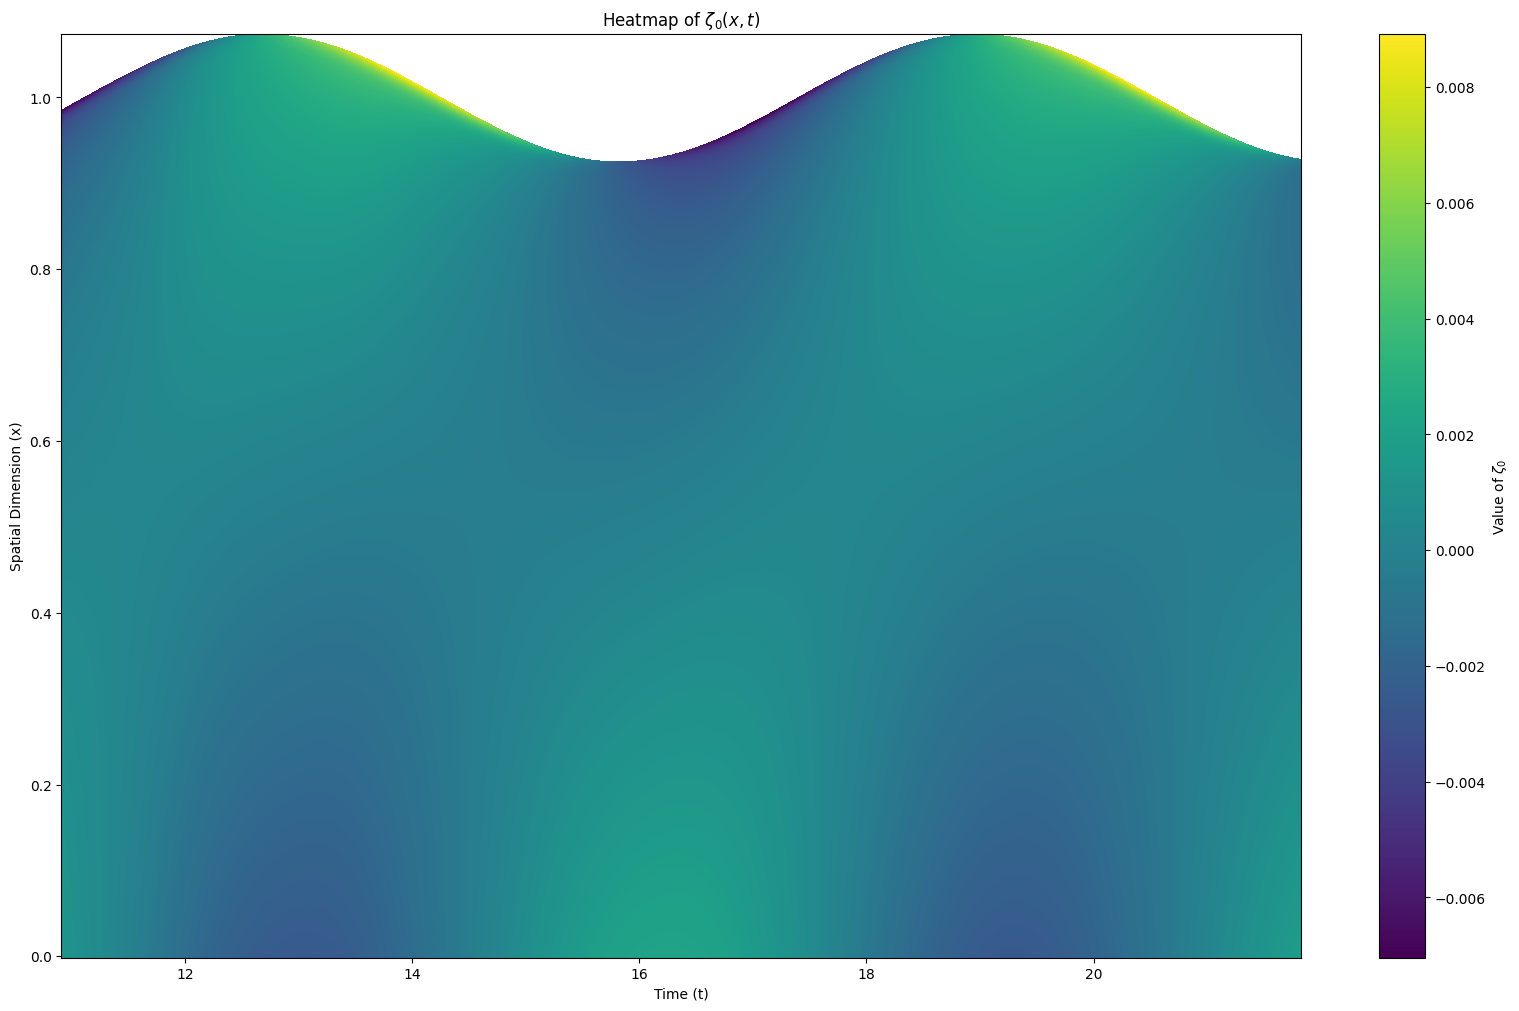

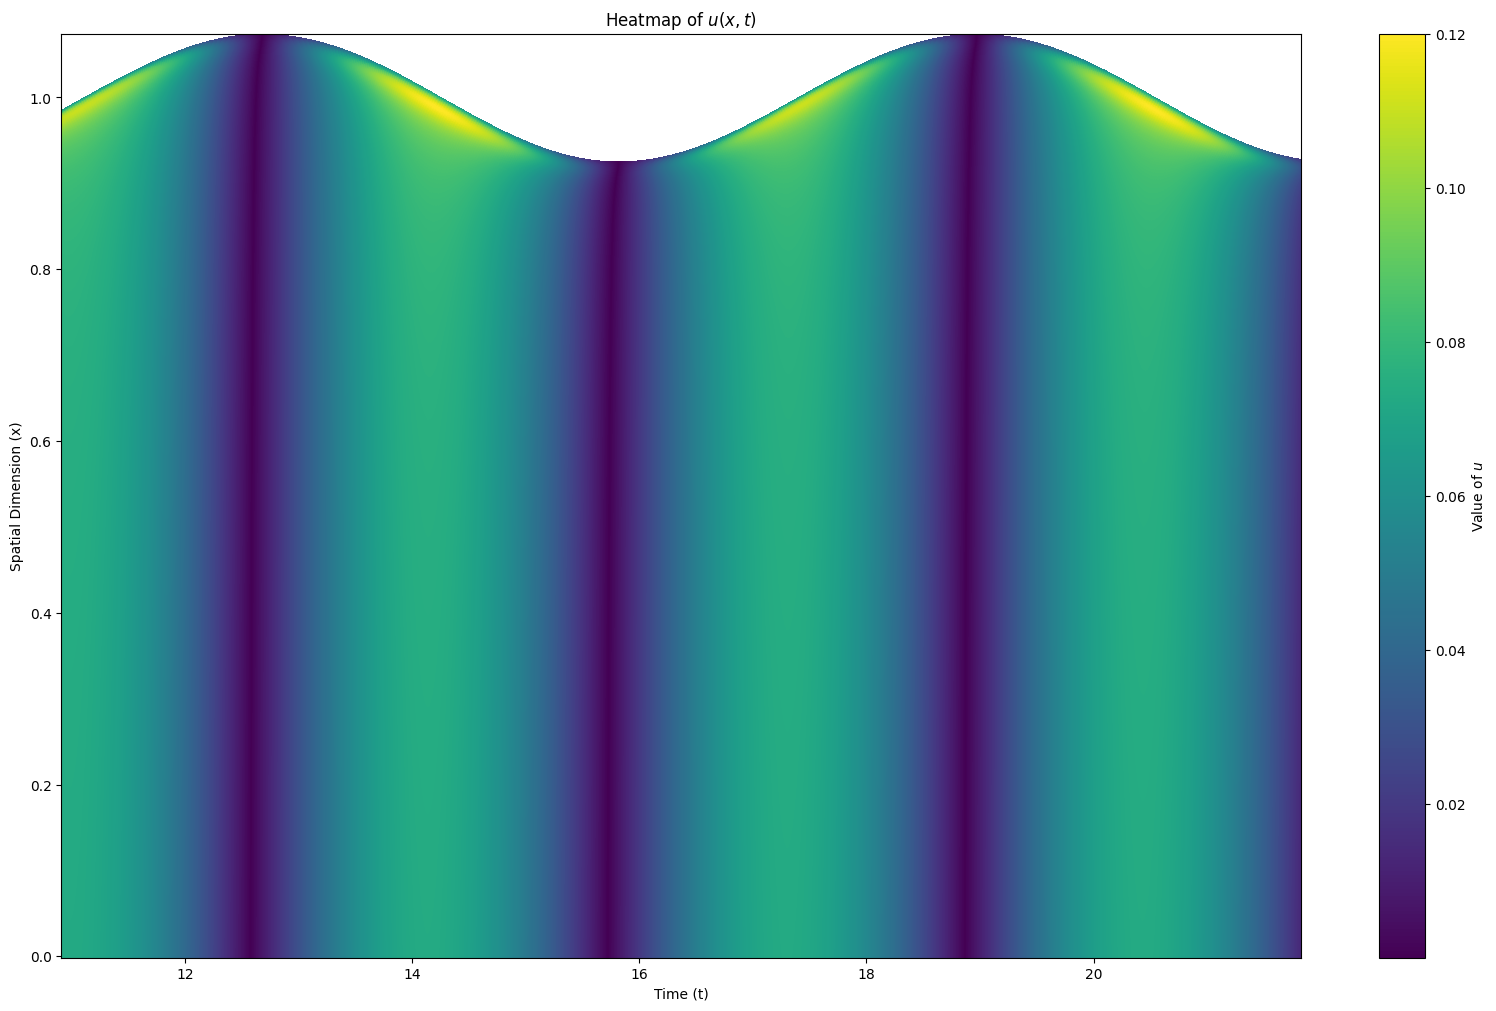

In [25]:


fig, ax = plt.subplots()

T_mesh = np.tile(t[start:end:step], (len(x_x), 1))
# X_mesh = np.tile((x_x*l_t).reshape(-1, 1), (1, len(t)))
X_mesh = x_x[:, np.newaxis] * l_t_[start:end:step][np.newaxis, :]


im = ax.pcolormesh(T_mesh, X_mesh, D_xt_[:, start:end:step] + X_mesh - np.mean(D_xt_[:, start:end:step] + X_mesh, axis=0), cmap='viridis', shading='nearest')
fig.colorbar(im, ax=ax, label='Value of $\\zeta_0$')

ax.set_xlabel('Time (t)')
ax.set_ylabel('Spatial Dimension (x)')
ax.set_title('Heatmap of $\\zeta_0(x,t)$')

plt.show()



fig, ax = plt.subplots()

T_mesh = np.tile(t[ start:end:step], (len(x_x), 1))
# X_mesh = np.tile((x_x*l_t).reshape(-1, 1), (1, len(t)))
X_mesh = x_x[:, np.newaxis] * l_t_[ start:end:step][np.newaxis, :]


im = ax.pcolormesh(T_mesh, X_mesh, abs(u_xt_[:, start:end:step]), cmap='viridis', shading='nearest')
fig.colorbar(im, ax=ax, label='Value of $u$')

ax.set_xlabel('Time (t)')
ax.set_ylabel('Spatial Dimension (x)')
ax.set_title('Heatmap of $u(x,t)$')

plt.show()



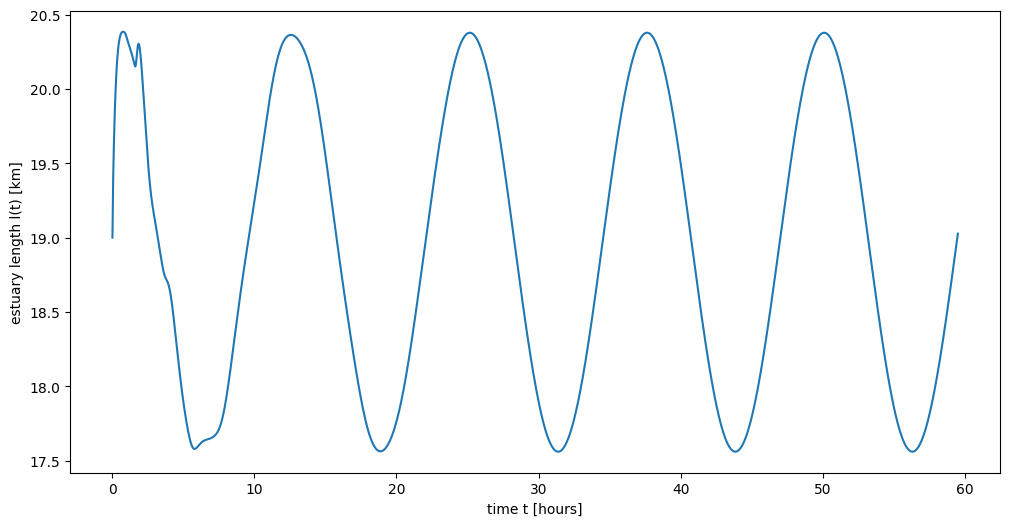

In [5]:
plt.plot(t / omega / 3600, l_t_ * L / 1000)
plt.xlabel("time t [hours]")
plt.ylabel("estuary length l(t) [km]")
plt.show()

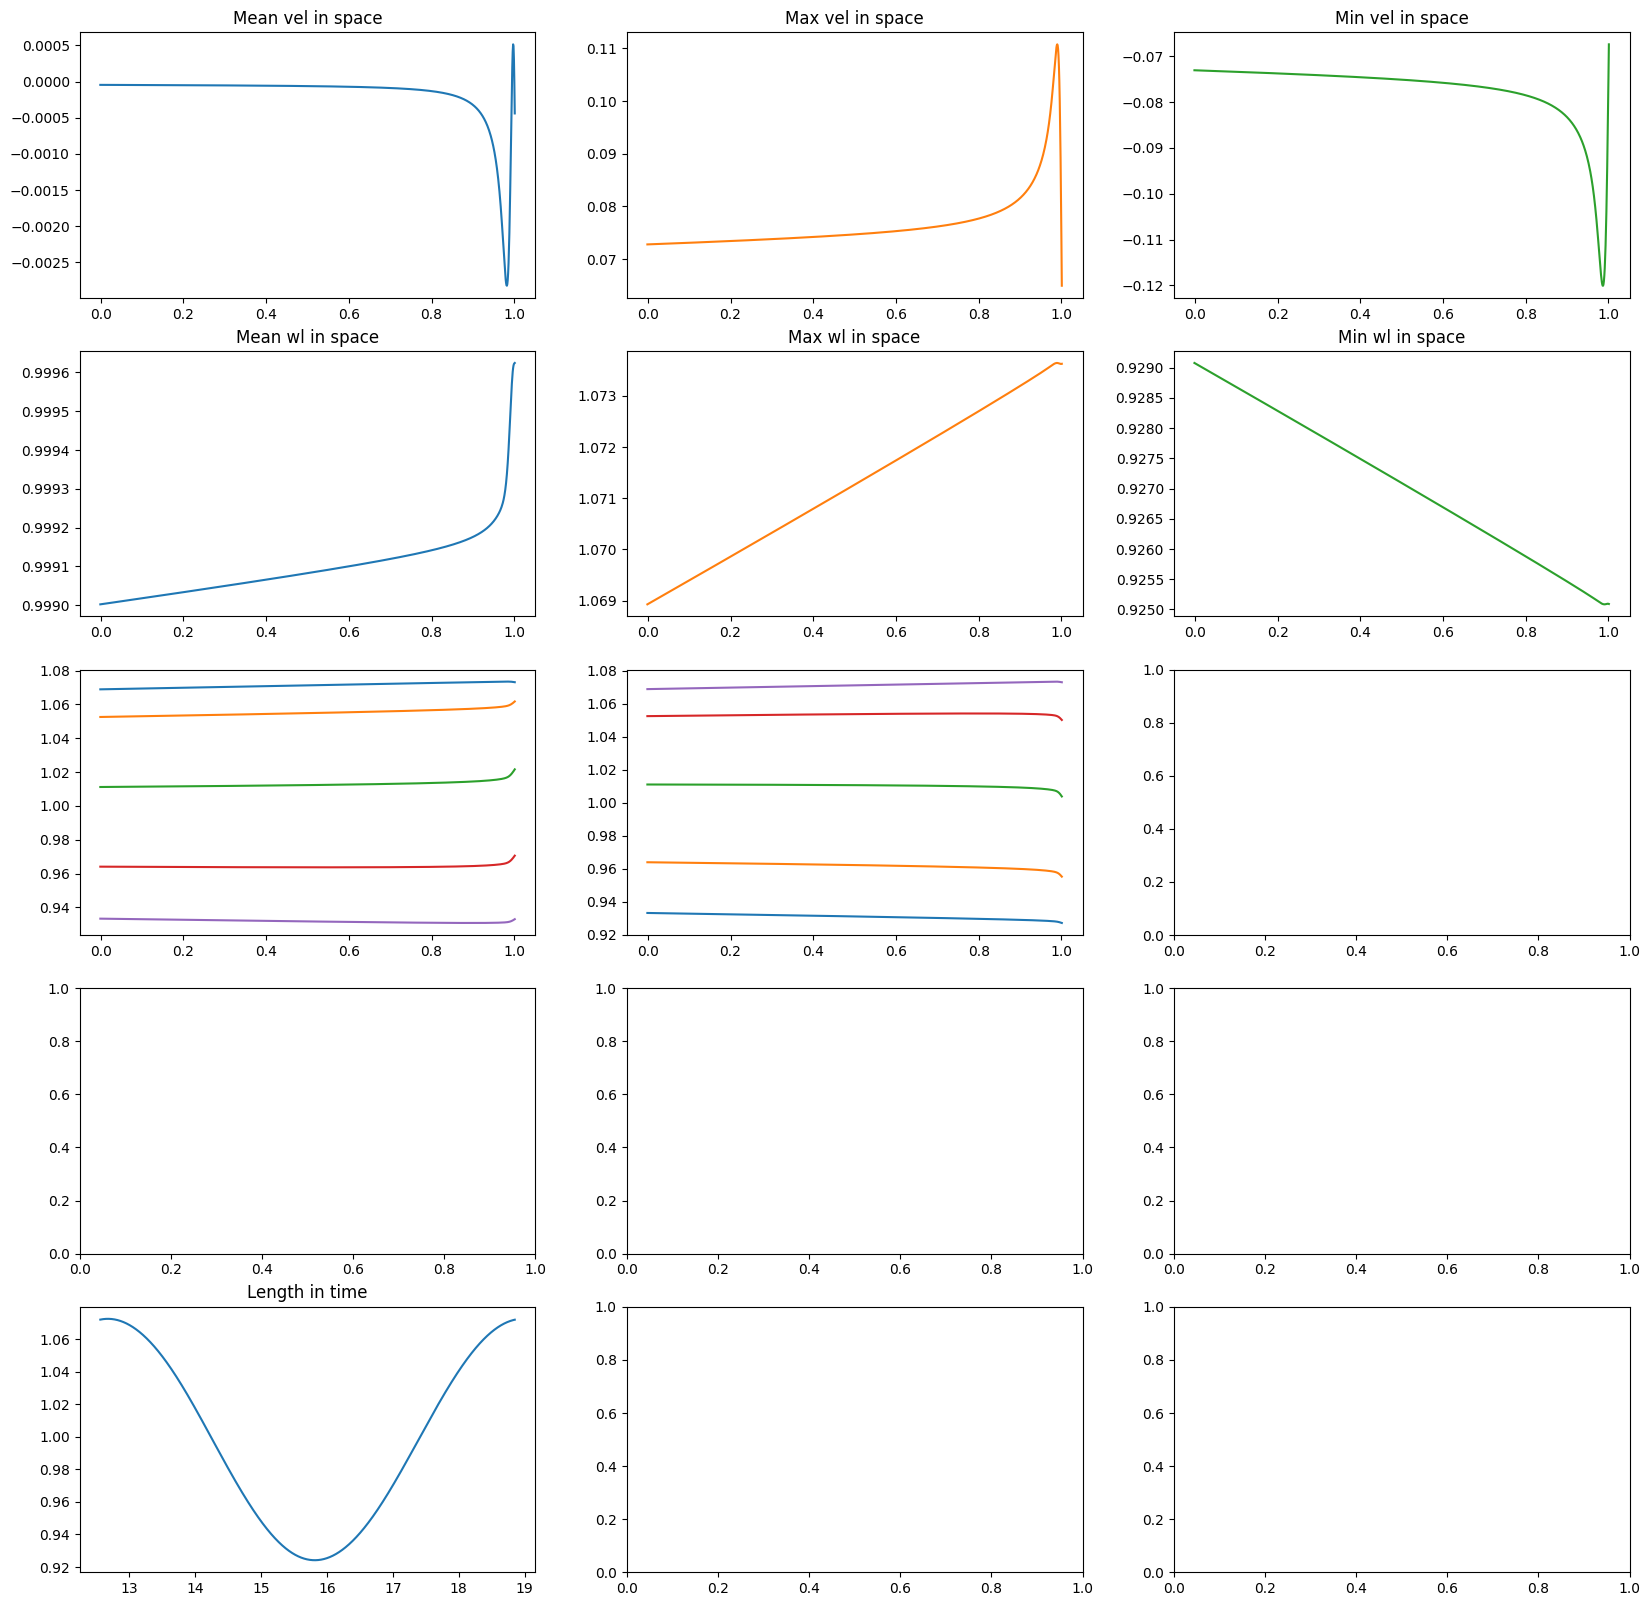

In [6]:

# extract one period
t1_idx = np.argmin(np.abs(t - 2 * (2*np.pi)))
t2_idx = np.argmin(np.abs(t - 3 * (2*np.pi)))


h_x = np.outer(x_x, l_t_)

D_xt_per = D_xt_[:, t1_idx:t2_idx]
u_xt_per = u_xt_[:, t1_idx:t2_idx]
l_t_per = l_t_[t1_idx:t2_idx]
t_per = t[t1_idx:t2_idx]
h_x_per = h_x[:, t1_idx:t2_idx]

dz = h_x_per + D_xt_per

n_moments = 10
sample_idx = np.round(linspace(0, len(t_per) - 1, n_moments)).astype(int)


fig, axs = plt.subplots(5, 3, figsize=(20, 20))




axs[0, 0].plot(x_x, mean(u_xt_per, 1))
axs[0, 0].set_title('Mean vel in space')
axs[0, 1].plot(x_x, max(u_xt_per, 1), 'tab:orange')
axs[0, 1].set_title('Max vel in space')
axs[0, 2].plot(x_x, min(u_xt_per, 1), 'tab:green')
axs[0, 2].set_title('Min vel in space')

axs[1, 0].plot(x_x, mean(dz, 1))
axs[1, 0].set_title('Mean wl in space')
axs[1, 1].plot(x_x, max(dz, 1), 'tab:orange')
axs[1, 1].set_title('Max wl in space')
axs[1, 2].plot(x_x, min(dz, 1), 'tab:green')
axs[1, 2].set_title('Min wl in space')

axs[2, 0].plot(x_x, dz[:, sample_idx[:n_moments//2]])
axs[2, 1].plot(x_x, dz[:, sample_idx[n_moments//2:]])




axs[4, 0].plot(t_per, l_t_per)
axs[4, 0].set_title('Length in time')




# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# plt.savefig("test.png")
plt.show()

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [7]:
print(u_xt_.shape)
print(t1_idx)
print(t2_idx)
print(t)
print(t_per.shape)

h_x = np.outer(x_x, l_t_)
print(h_x.shape)

print(len(t_per))
print(sample_idx)

(1002, 137437)
57569
86354
[0.00e+00 2.18e-04 4.37e-04 ... 3.00e+01 3.00e+01 3.00e+01]
(28785,)
(1002, 137437)
28785
[    0  3198  6396  9595 12793 15991 19189 22388 25586 28784]


[86354, 88410, 90466, 92522, 94578, 96634, 98690]


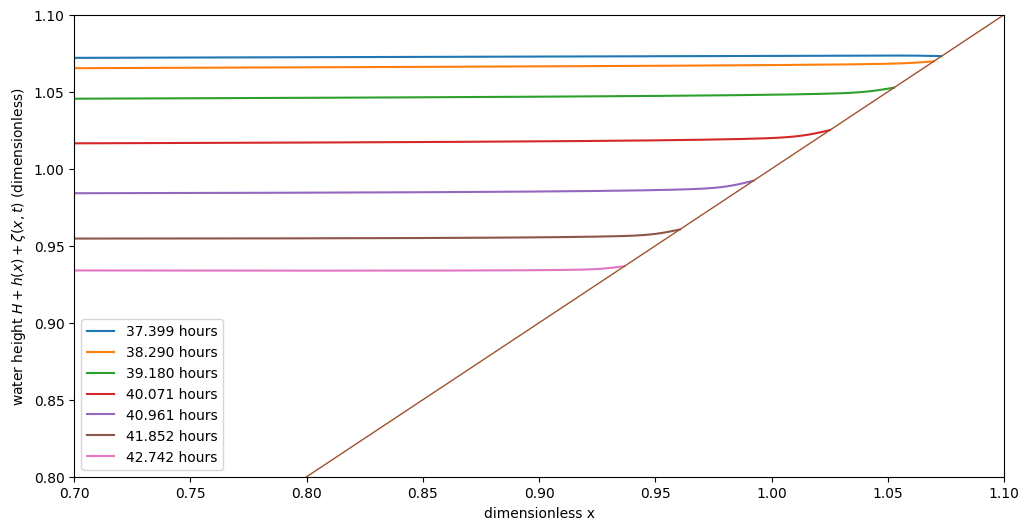

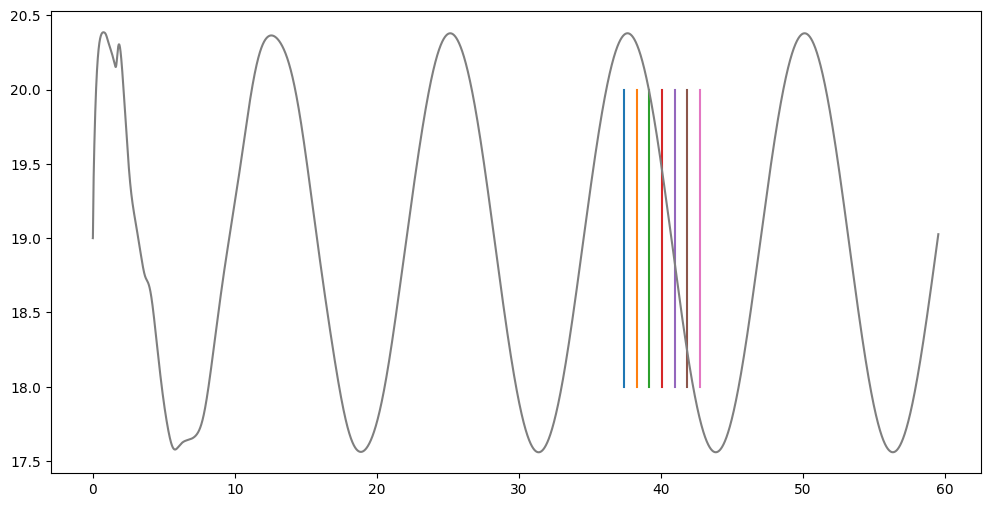

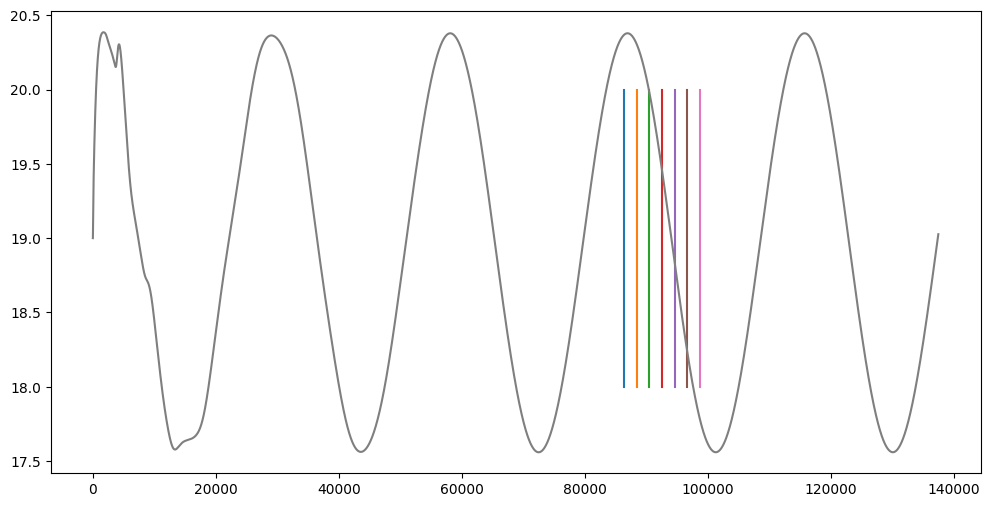

In [8]:
t1_idx = np.argmin(np.abs(t - 3 * (2*np.pi)))
t2_idx = np.argmin(np.abs(t - 4 * (2*np.pi)))

n = 15
target_time_idxs = [int(x) for x in np.linspace(t1_idx, t2_idx, n)][:n // 2]
# target_time_idxs = [np.argmin(np.abs(t - target_time * 2 * np.pi)) for target_time in target_times]
print(target_time_idxs)




for target_time_idx in target_time_idxs:
    # D = (D_xt_[:, target_time_idx] + x_x * l_t_[target_time_idx]) /  l_t_[target_time_idx]
    D = (D_xt_[:, target_time_idx] + x_x * l_t_[target_time_idx])# /  l_t_[target_time_idx]


    plt.plot(x_x * l_t_[target_time_idx], D)
    

plt.plot(x_x * 2, x_x * 2, 'sienna', linewidth=1)
plt.xlim([0.7, 1.1])
plt.ylim([0.8, 1.1])
plt.xlabel(r"dimensionless x")
plt.ylabel(r"water height $H + h(x) + \zeta(x,t)$ (dimensionless)")
plt.legend([str(t[target_time_idx] / omega / 3600)[:6] + " hours" for target_time_idx in target_time_idxs])



# plt.plot(t[:target_time_idx] / omega / 3600, l_t_[:target_time_idx] * L / 1000)
plt.show()



T = (2*np.pi) / omega

for idx in target_time_idxs:
    plt.plot(np.array([t[idx], t[idx]]) / omega / 3600, [18, 20])

plt.plot(t / omega / 3600, l_t_ * L / 1000)

plt.show()



for idx in target_time_idxs:
    plt.plot(np.array([idx, idx]), [18, 20])
plt.plot(l_t_ * L / 1000)
plt.show()



137437
43177
9.424764613974375
9.42477796076938
57569
12.56628005794499
12.566370614359172
[1.87e+01 1.90e+01 1.93e+01 1.97e+01 2.00e+01 2.03e+01 2.06e+01 2.10e+01
 2.13e+01 2.16e+01 2.19e+01 2.23e+01 2.26e+01 2.29e+01 2.32e+01]


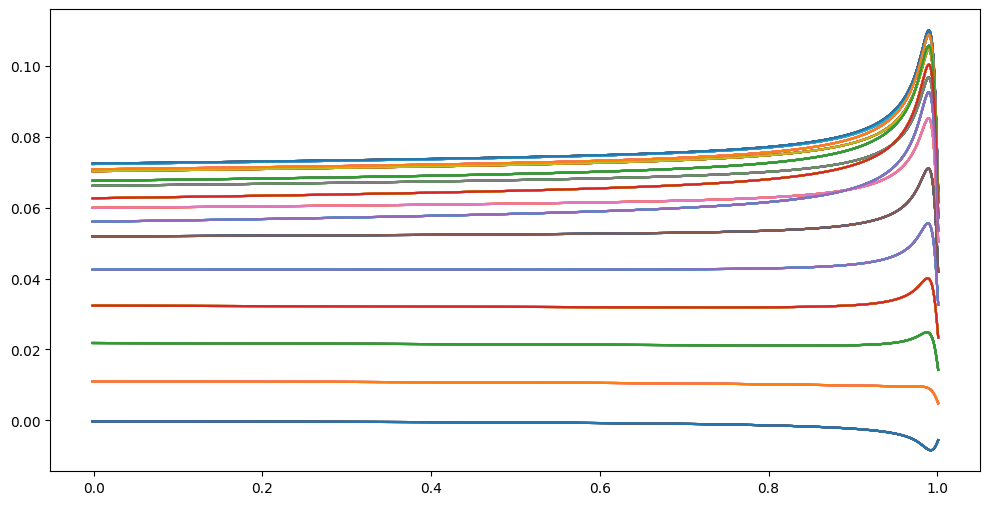

In [9]:
print(len(t))

n = 15

t_idx_min = np.argmin(np.cos(t[40000:50000])) + 40000
print(t_idx_min)
t_min = t[t_idx_min]
print(t_min)
print(3 * np.pi)



t_idx_min2 = np.argmin(np.abs(t - 4 * np.pi))

print(t_idx_min2)
print(t[t_idx_min2])
print(4 * np.pi)



moments =  np.array(range(n)) * 750 + t_idx_min

for moment in moments:
    plt.plot(x_x, u_xt_[:, moments])
# plt.legend(t[moments] / omega / 3600)
print(t[moments] / omega / 3600)
plt.show()



0.002182820625326997 0.01
(102, 13744)
0.0004365641250653994 0.002
(502, 68719)
0.0002182820625326997 0.001
(1002, 137437)


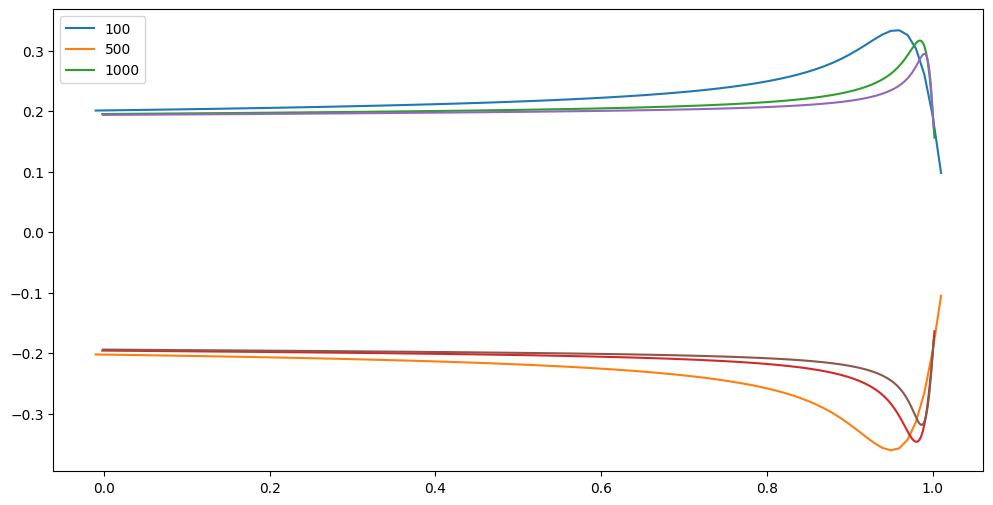

In [10]:
U = omega * L
nxs =  [100, 500, 1000]
for nx in nxs:
    t, x_x, l_t_, D_xt_, u_xt_ = perform_numerical_computation(A, kappa, H, r, h0, nx)
    maximum_velocities = [max(u_xt_[x, len(l_t_) * 3 // 4:]) for x in range(u_xt_.shape[0])]

    print(u_xt_.shape)

    plt.plot(x_x, np.array(maximum_velocities) * U)


    minimum_velocities = [min(u_xt_[x, len(l_t_) * 3// 4:]) for x in range(u_xt_.shape[0])]

    plt.plot(x_x, np.array(minimum_velocities) * U)

plt.legend(nxs)
plt.show()

43177
9.424764613974375
9.42477796076938
57569
12.56628005794499
12.566370614359172
(1002, 137437)


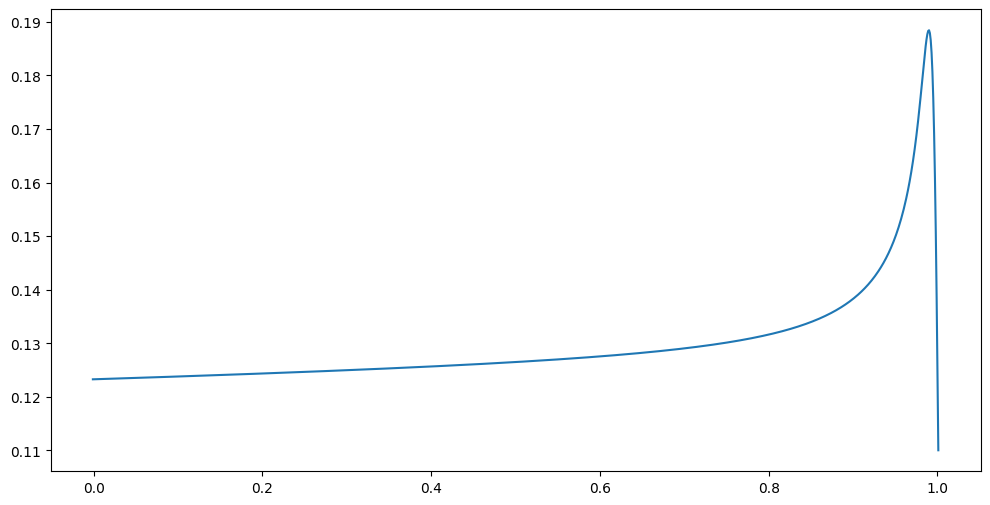

In [11]:



t_idx_min = np.argmin(np.cos(t[40000:50000])) + 40000
print(t_idx_min)
t_min = t[t_idx_min]
print(t_min)
print(3 * np.pi)



t_idx_min2 = np.argmin(np.abs(t - 4 * np.pi))

print(t_idx_min2)
print(t[t_idx_min2])
print(4 * np.pi)


avg_velocities = [mean(u_xt_[x, t_idx_min:t_idx_min2]) for x in range(u_xt_.shape[0])]

print(u_xt_.shape)

plt.plot(x_x, np.array(avg_velocities) * U)





In [12]:
R = omega * H

print(x_x.shape, l_t_.shape)
h_xt_ = x_x.reshape(len(x_x), 1) @ l_t_.reshape(len(l_t_), 1).T 
print(h_xt_.shape)
print(u_xt_.shape)


rho = 1000
tau_xt_ = rho * (u_xt_ * U) * (r * R) / (D_xt_ * H + h0 * H) * (D_xt_ * H + h0 * H) / H #?
tau_xt2 = rho * r * u_xt_ / (D_xt_ * H + h0 * H) * (U * omega) * (D_xt_ * H + h0 * H) * H # ??




print(np.max(u_xt_ * U))
print(r * R)
print(np.max(D_xt_ * H + h_xt_ * H))

print(tau_xt_.shape)
print(sum(sum(np.abs(tau_xt_ - tau_xt2)))) # they are the same
# print(tau_xt2)



(1002,) (137437,)
(1002, 137437)
(1002, 137437)


KeyboardInterrupt: 

43177
9.424764613974375
9.42477796076938
[1.87e+01 1.90e+01 1.93e+01 1.97e+01 2.00e+01 2.03e+01 2.06e+01 2.10e+01
 2.13e+01 2.16e+01 2.19e+01 2.23e+01 2.26e+01 2.29e+01 2.32e+01]


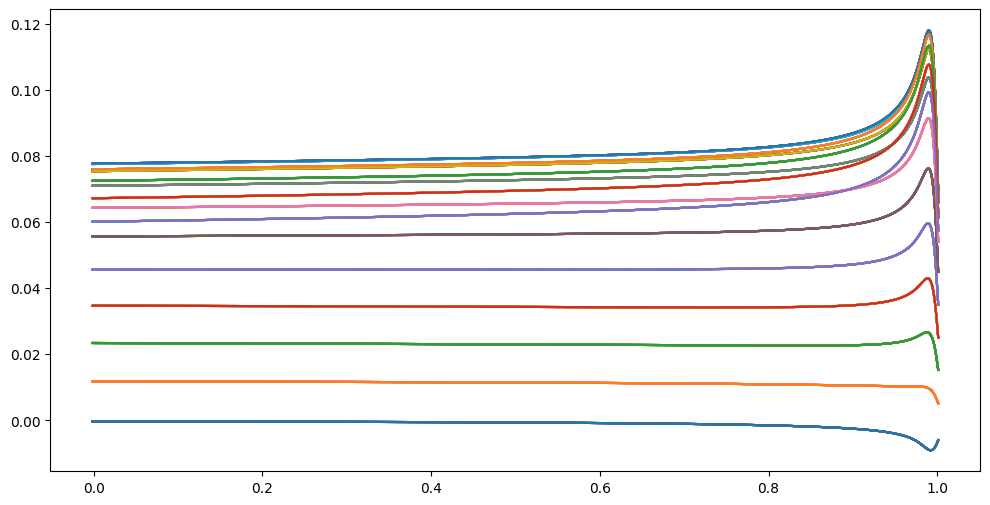

In [ ]:

n = 15

t_idx_min = np.argmin(np.cos(t[40000:50000])) + 40000
print(t_idx_min)
t_min = t[t_idx_min]
print(t_min)
print(3 * np.pi)

moments =  np.array(range(n)) * 750 + t_idx_min

for moment in moments:
    plt.plot(x_x, tau_xt_[:, moments])
# plt.legend(t[moments] / omega / 3600)
print(t[moments] / omega / 3600)
plt.show()


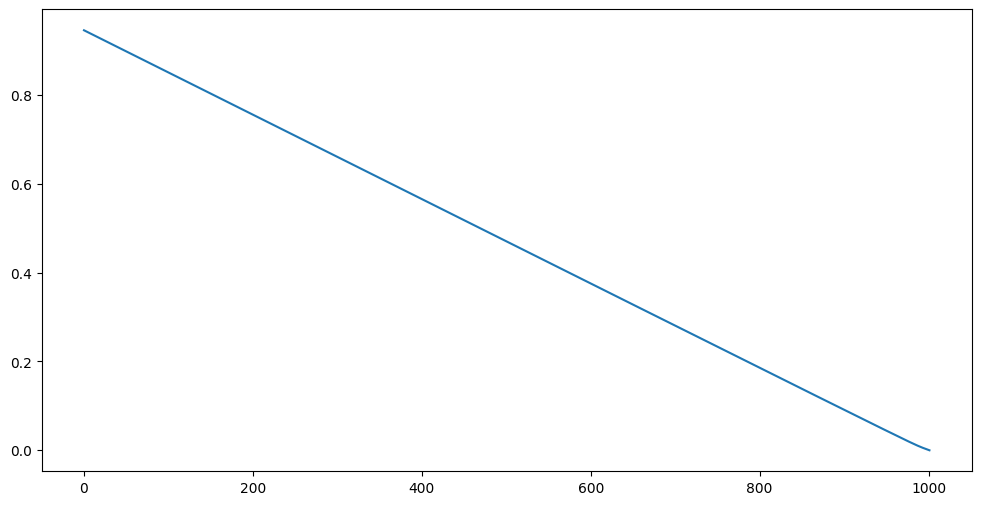

In [ ]:
plt.plot(D_xt_[:, 40000])
plt.show()